# Unsupervised Pattern Discovery
Much of radio astronomy relies on retrieving meaningful patterns from noisy data. When multiple instances of an example signal are available, they can be averaged to achieve a higher signal to noise ratio. However, all existing methods require knowing details about the target signal, often from domain spefic knowledge. 

This work focuses on two dimensional data. In radio science, this is the spectrograms (power as function of time and frequency). For example, pulsar signals incur dispersion due to interstellar medium and thus have a quadratic shape in the spectrogram. When the target shape is known, one can sum over the frequency channels with appropriate time delays to achive higher signal to noise ratio, a process known as dedispersion. The dedispersion search process is equivalent to convolution with a binary kernel of the target signal shape. In this work, we develop methods to automatically learn the convolutional kernels that picks out repeating signals in the data. 

The goal is thus two fold:
1. Learn convolutional kernels from reapeating patterns in the data
2. Use multiple instances of said pattern to achieve a clearer kernel. 

At this point, there are multiple approaches at various stages. 

## Data Generation
We generate 2d image data with normal iid noise. We inject 3 types of signals with varying probability.

In [1]:
%matplotlib inline
#from blimpy import Waterfall
import pylab as plt
import numpy as np
from skimage.draw import (line, polygon, circle,
                          circle_perimeter,
                          ellipse, ellipse_perimeter,
                          bezier_curve)
from skimage import measure
import scipy.signal as scisig
from skimage.morphology import binary_dilation
from sklearn.cluster import DBSCAN, AgglomerativeClustering
import torch
#import tensorflow as tf
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.667)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

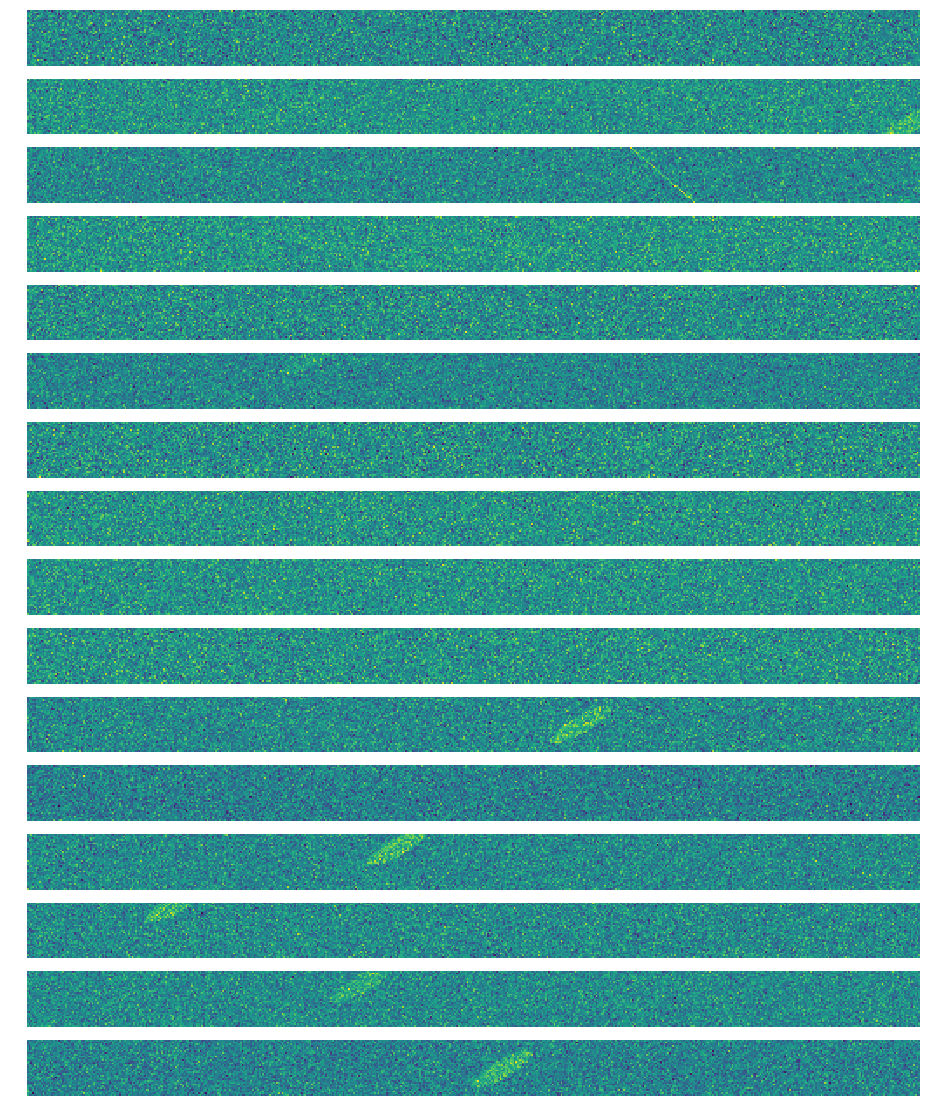

In [2]:
# create training set of size 1000 * 32 * 512, inject 3 types of signals
n_img = 1000
shape0 = (32, 512)
p_ellip = 0.5; ellp_pop = np.random.uniform(size=n_img)<p_ellip  #labels
p_line = 0.1; line_pop = np.random.uniform(size=n_img)<p_line
p_circp = 0.01; circp_pop = np.random.uniform(size=n_img)<p_circp
img = np.random.normal(size=n_img*64*256).reshape(n_img, 32, 512)

for i in range(n_img):
    
    if line_pop[i]:
        start, length = np.random.randint(low=0, high=420), np.random.choice([32,36])
        #print('line', i, start, length)
        rr, cc = line(0, start, 31, start+length)
        img[i, rr, cc] += np.random.uniform(low=0.5, high=4)
    if ellp_pop[i]:
        x, y = np.random.randint(low=0, high=31), np.random.randint(low=0, high=511)
        rr, cc = ellipse(x, y, 5, 20, shape0, rotation=np.pi/6)
        #print('ellp', i, x, y)
        
        img[i, rr, cc] += np.random.uniform(low=0.5, high=2)
    if circp_pop[i]:
        x, y = np.random.randint(low=0, high=31), np.random.randint(low=0, high=511)
        rr, cc = circle_perimeter(x, y, radius=15, shape=shape0)
        #print(i)
        img[i, rr, cc] += np.random.uniform(low=0.5, high=4)

f, ax = plt.subplots(16, 1, figsize=(16, 20))
for i in range(16):
    ax[i].imshow(img[i,:,:512])
    ax[i].axis('off')
#plt.savefig('/home/yunfanz/Projects/presentations/datagen.jpg')
plt.show()

## Phase 0: Thresholding and Kernel Initialization
With minimal assumption on the signal shape, we perform energy detection for excess power in a patch. In practice, mulitple shapes and sizes need to be tried. 

In [3]:
# initialize kernels by convolution and thresholding
#init_thresh = 3.
pix_thresh = 2 #sigma
filter_shape = (32,64)
filt = np.ones(filter_shape, dtype=np.float32)
filt /=  np.sqrt(np.sum(filt**2))

bina = (img>pix_thresh).astype(np.float32)

act = np.hstack([scisig.fftconvolve(b, filt, 'same') for b in (bina*img)])  
#convolving with thresholded array is better to detect signals with low support


In [4]:

# split resulting regions into kernels

def get_labels(T, dilation=None):
    """label thresholded into segmented regions
       dilation: None or tuple for (nrows, ncols)"""
    if dilation is not None:
        T2 = binary_dilation(T.copy(), selem=np.ones(dilation))
        labels = measure.label(T2) * T
        return labels
    else:
        return measure.label(T)
    
pad = 64
T = act>4.5  # hyper-parameter, ajust for false positive rate
lab = get_labels(T, dilation=(4,8))

kernels = []
img = np.hstack([im for im in img])
regions = measure.regionprops(label_image=lab, intensity_image=img)
for r in regions:
    row, col = np.asarray(r.weighted_centroid, dtype=np.int32)
    col = max(col, pad//2); col = min(col, img.shape[1]-pad//2)
    kernels.append(img[:,col-pad//2:col+pad//2])
    
kernels = np.asarray(kernels)
print(kernels.shape)

(415, 32, 64)


## Phase 1: Unsupervised Kernel determination

Next have two steps:
1. Cluster based on distance metric from cross correlations. 
2. PCA on each cluster combines the multiple instances of the same patterns into a few high quality kernels. 

The subsequent steps can also be tried with a deep auto-encoder. 

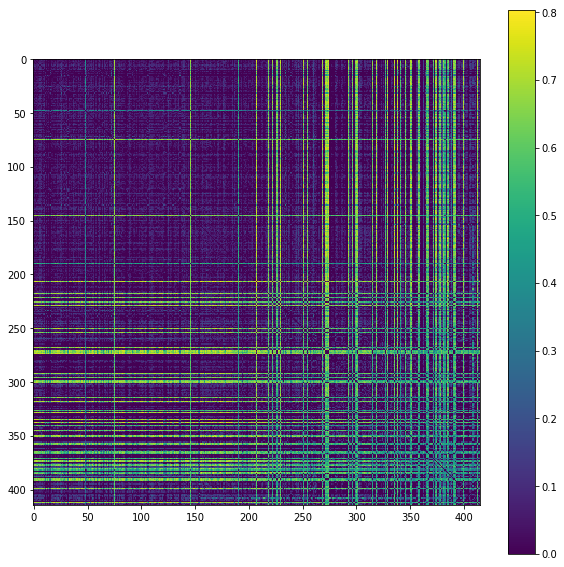

In [5]:
#compute affinity matrices based on the cross-correlation of the kernels with respect to each other
from time import time
#import fftconv
def cross_correlate_kernels(kernels, target='cpu', session=None):
    nkerns = kernels.shape[0]
    corr_mat = np.ones((nkerns,nkerns))

    if target.startswith('tf'):
        assert session is not None
        
        tf_img = tf.constant(np.expand_dims(kernels, axis=-1), dtype=tf.float32)
        tf_fil = tf.constant(np.expand_dims(kernels, axis=-1), dtype=tf.float32)
        
        if target == 'tf_conv':
            tf_fil = tf.transpose(tf_fil, perm=[1,2,3,0])
            print(tf_fil.get_shape(), tf_img.get_shape())
            convolved = tf.nn.conv2d(tf_img, tf_fil, strides=[1,1,1,1], padding="SAME")
            #TODO this doesn't give same results as other two methods
        elif target == 'tf_fft':
            tf_fil = tf.transpose(tf_fil, perm=[3,1,2,0])
            convolved = fftconv.fftconv(tf_img, tf_fil, padding="same")
        cov_mat = tf.reduce_max(convolved, axis=[1,2]).eval(session=session)
        shift_mat = tf.argmax(tf.reshape(convolved,[nkerns,-1,nkerns]), axis=1).eval(session=session)
        
        for i in range(cov_mat.shape[0]):
            for j in range(cov_mat.shape[0]):
                corr = cov_mat[i,j]/np.sqrt(cov_mat[i,i]*cov_mat[j,j])
                corr_mat[i,j] = corr
        
    elif target == 'cpu':
        cov_mat = np.ones((kernels.shape[0],kernels.shape[0]))
        shift_mat = np.ones((kernels.shape[0],kernels.shape[0]))
        #get diagonal
        diags = []
        for i,k in enumerate(kernels):
            a = scisig.fftconvolve(kernels[i], kernels[i], 'same')
            diags.append(np.amax(a))
            shift_mat[i,i] = 0

        for i,k in enumerate(kernels):
            for j,m in enumerate(kernels):
                a = scisig.fftconvolve(kernels[i], kernels[j], 'same')
                cov_mat[i,j] = np.amax(a)
                a /= np.sqrt(diags[i]*diags[j])
                corr_mat[i,j] = np.amax(a)
                shift_mat[i,j] = np.argmax(a)
                #im = axes[i,j].imshow(a)
                #fig.colorbar(im, ax=axes[i,j])
    return corr_mat, cov_mat, shift_mat
# t0 = time()
corr_mat, cov_mat, shift_mat = cross_correlate_kernels(kernels)

# t1 = time()
#corr_mat2, cov_mat2, shift_mat2 = cross_correlate_kernels(kernels[:100], target='tf_conv', session=sess)
# t2 = time()
# corr_mat3, cov_mat3, shift_mat3 = cross_correlate_kernels(kernels[:100], target='tf_fft', session=sess)
# t3 = time()
# print(t1-t0, t2-t1, t3-t2)
cen_row, cen_col = np.unravel_index(np.asarray(shift_mat, dtype=np.int32), dims=kernels[0].shape)

affinity_mat = np.clip(1-corr_mat, 1.e-16, 1)
plt.figure(figsize=(10,10))
plt.imshow(affinity_mat)
plt.colorbar()
plt.show()

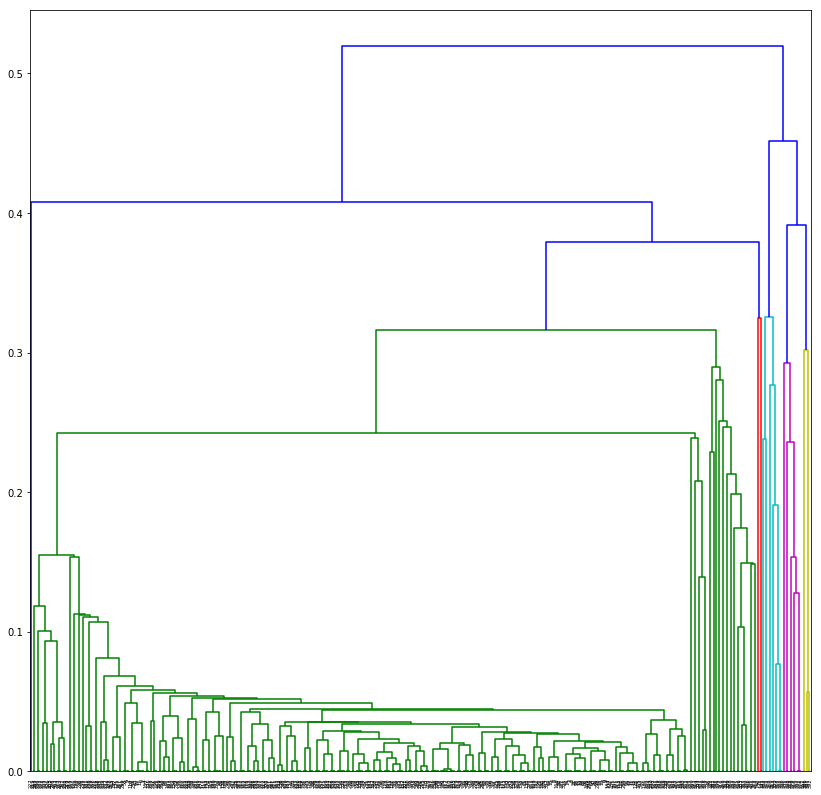

In [6]:
from scipy.cluster import hierarchy
affinity_condensed = affinity_mat[np.triu_indices(affinity_mat.shape[0])]
Z = hierarchy.linkage(affinity_condensed, 'average')
plt.figure(figsize=(14,14))
dn = hierarchy.dendrogram(Z)
plt.show()

In [7]:

def _get_shifted(k1, k0, shift):
    """
    function to return k1 shifted with respect to k0, padding with k0
    shift is the delta of k1 with respect to k0
    """
    
    SR,SC = k0.shape
    res = k0
    sr, sc = shift
    if sr >= 0 and sc >=0:
        res[sr:,sc:] = k1[:SR-sr, :SC-sc]
    elif sr >= 0 and sc < 0:
        res[sr:,:SC+sc] = k1[:SR-sr, -sc:]
    elif sr < 0 and sc < 0:
        res[:SR+sr,:SC+sc] = k1[-sr:, -sc:]
    elif sr < 0 and sc >=0:
        res[:SR+sr,sc:] = k1[-sr:, :SC-sc]
    return res
    
def combine_filters(kernels, evals, vecs, shifts, cutoff=0.1):
    """
    Function to combine set of kernels by weighted averaging
    """
    sort_inds = np.argsort(evals)[::-1]
    vecs = vecs[sort_inds]
    evals = evals[sort_inds]
    new_kernels = np.zeros_like(kernels)
    for i, vec in enumerate(vecs):
        if evals[i] < cutoff*evals[0]:
            break
        vec /= np.sqrt(np.sum(vec**2))
        main = np.argmax(np.abs(vec))
        if vec[main] < 0:
            vec = -vec
        shift = shifts[main]
        shift = (shift[main] - shift) #shift_shape is (col, srow, scol), it's the 
        kern_main = kernels[main].copy()
        for j, alpha in enumerate(vec):
            kernj = kernels[j].copy()
            
            if j != main:
                kernj = _get_shifted(kernj, kern_main.copy(), shift[j])
            new_kernels[i] += alpha * kernj
    return new_kernels
        
def get_distance(ker1, ker2):
    mag1 = np.amax(scisig.fftconvolve(ker1, ker1, 'same'))
    mag2 = np.amax(scisig.fftconvolve(ker2, ker2, 'same'))
    #norm = np.sqrt(np.sum(ker1*ker1)*np.sum(ker2*ker2))
    norm = np.sqrt(mag1 * mag2)
    max_conv = np.amax(scisig.fftconvolve(ker1, ker2, 'same'))
    dis = np.clip(1-max_conv/norm, 0, 1)
    return dis

evals [1206.23000792 -109.59537557  180.95898162  128.2933826     6.92779011]


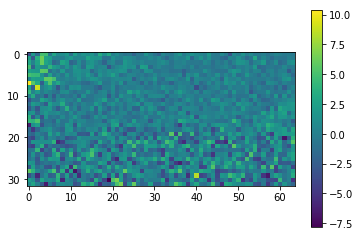

evals [8459.96611308 -252.01191103 -234.19355444  234.90185027  218.59108415]


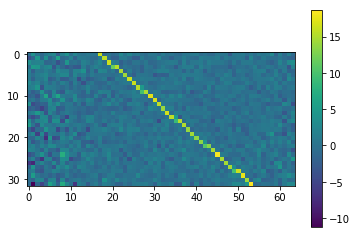

evals [204342.62813357 -10795.88407534   3681.107625     1584.67754276
  -1163.47559978]


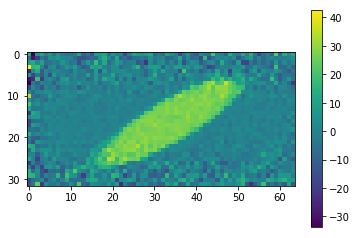

evals [2284.30843403 -262.19278773   98.0656904    21.8820346   -13.96649226]


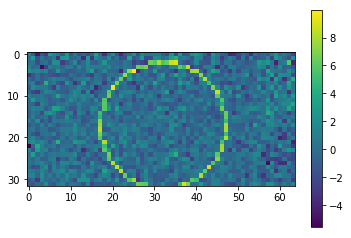

evals [7491.1150793   244.30946123 -200.97878507  187.25771123  161.97324511]


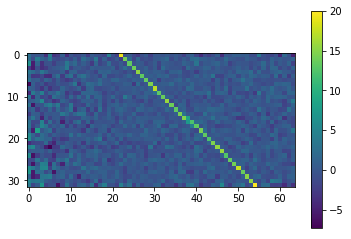

In [8]:
# First cluster with respect to affinity matrix. 
# If clustering succeeds, reduces pca orthogonality constraint
#scanner = DBSCAN(eps=0.1, min_samples=2, metric="precomputed")
scanner = AgglomerativeClustering(n_clusters=5, linkage='average', affinity='precomputed')
clustering = scanner.fit(affinity_mat)
labels = np.unique(clustering.labels_)
clusters = []
for lab in labels:
    if lab < 0:
        continue
    clusters.append(np.where(clustering.labels_==lab)[0])
#print("cluster", clusters)


#Perform PCA on covariance matrices to keep the best components
new_kerns = []
distances = [] #
queues = []  #images to characterize distribution of cluster
qsz = 100
for c in clusters:
    c = np.asarray(c)
    kerns = kernels[c]
    if c.size == 1:
        new_kerns.append(kerns[0])
        plt.figure()
        plt.imshow(kerns[0])
        plt.colorbar()
        plt.show()
        continue
    Y = cov_mat[np.ix_(c,c)]
    R = cen_row[np.ix_(c,c)]
    C = cen_col[np.ix_(c,c)]
    w, v = np.linalg.eig(Y)
    print('evals', w[:5])
    res = combine_filters(kerns, w, v.T, np.stack([R, C], axis=-1))
    j = 0
    while w[j] > max(w[0]*0.1, 1000):
        dis = [get_distance(res[j], kern) for kern in kerns]
        distances.append(dis)
        queue = [kern for kern in kerns[:min(kerns.shape[0], qsz)]]
        queues.append(queue)
        new_kerns.append(res[j])  #only append first result from each cluster
        plt.figure()
        plt.imshow(res[j])#*(res[j]>0))
        plt.colorbar()
        plt.show()
        j += 1

In [9]:
for i, d in enumerate(distances):
    print(len(d), len(queues[i]), np.mean(d), np.std(d), np.sqrt(np.mean(np.asarray(d)**2)))
a = np.random.normal(size=(32,64))
for k in new_kerns:
    print(get_distance(k, a))
for k in new_kerns:
    diss = [get_distance(k, k2) for k2 in new_kerns]
    print(diss)

8 8 0.20653319574433826 0.1353328148737769 0.2469229266917698
20 20 0.041646241656194884 0.05957794430835607 0.0726907208115022
363 100 0.069874758246693 0.051345722094568766 0.08671138920260982
5 5 0.029359116937004437 0.05292455697167045 0.06052244606729219
19 19 0.06240087489169992 0.04197286841399867 0.0752036626112614
0.3256904216232316
0.6883782834843044
0.7995111026290782
0.6452857147787423
0.6424965753555282
[0.0, 0.6793693972785502, 0.4773365852108299, 0.6549391983259676, 0.73795297959883]
[0.6793693972785502, 0.0, 0.8656068427626649, 0.7937057285466163, 0.5833616370649395]
[0.4773365852108299, 0.8656068427626649, 0.0, 0.7784935385415955, 0.8751139151202634]
[0.6549391983259676, 0.7937057285466163, 0.7784935385415955, 0.0, 0.809755877802623]
[0.73795297959883, 0.5833616370649395, 0.8751139151202634, 0.809755877802623, 0.0]


Clustering sometimes doesn't work well, or requires good hyper-parameters, when the representation of the signals aren't balanced. This can be mitigated by first removing the highest contributing kernels to the highest PCA output. 

Things to try:
1. PCA and remove top element at a time. 
2. non negative matrix factorization (enforce translation)
3. ICA on PCA result (enforce translation)

## Phase 2: continued learning

We cannot perform phase 1 for extremely large datasets. Thus we continue to learning iteratively. This phase alternates between detecting signals (new and old types), and clustering and consolidating them. Similar to an EM algorithm, we have two steps:
1. find signals that belong with old kernels, and new signals types that need their own kernels. 
2. update the set of kernels. Improve the old and add the new. 
These can be repeated every 500 detections or so. 

In [10]:
#normalize filters

# filter_shape = (32,64)
# filt = np.ones(filter_shape, dtype=np.float32)
# filt /=  filt.size

#new_kerns.append(filt)
# for k in new_kerns:
#     k /= np.sqrt(np.sum(k**2))
#     plt.figure()
#     plt.imshow(k)
#     plt.colorbar()
#     plt.show()

new_kerns = np.asarray(new_kerns)

### Step 1: Search

In [11]:
import torch
n_img = 2000
shape0 = (32, 512)
p_ellip = 0.2
p_line = 0.2
p_circp = 0.2
pad = 64
thresh = 5    #TODO: should replace by std calculated from each cluster above
alpha = 1.44  #larger alpha, the more likely detections will be put into new category


detections = []
for t in range(new_kerns.shape[0]):
    detections.append([])
active_kerns = new_kerns.copy()
active_kerns[-1] *= alpha
noises = []
for i in range(n_img):
    data = np.random.normal(size=32*512).reshape(32, 512)  #channel first
    if np.random.uniform()<p_line:
        start, length = np.random.randint(low=0, high=420), np.random.choice([32,36])
        rr, cc = line(0, start, 31, start+length)
        #print("Line at", start)
        data[rr, cc] += np.random.uniform(low=0.5, high=4)
    if np.random.uniform()<p_ellip:
        x, y = np.random.randint(low=0, high=31), np.random.randint(low=0, high=511)
        rr, cc = ellipse(x, y, 5, 20, shape0, rotation=np.pi/6)
        #print("ellp at", x, y)
        data[rr, cc] += np.random.uniform(low=0.5, high=2)
    if np.random.uniform()<p_circp:
        x, y = np.random.randint(low=0, high=31), np.random.randint(low=0, high=511)
        rad = np.random.choice([10,15])
        rr, cc = circle_perimeter(x, y, radius=rad, shape=shape0)
        #print("Circle at", x, y)
        data[rr, cc] += np.random.uniform(low=0.5, high=4)
    

    pix_thresh = 2 #sigma
    filter_shape = (32,64)
    filt = np.ones(filter_shape, dtype=np.float32)
    filt /=  np.sqrt(np.sum(filt**2))
    bina = (data>pix_thresh).astype(np.float32)

    #print(bina.shape, data.shape)
    act = scisig.fftconvolve((bina*data), filt, 'same')
    
    pad = 64
    T = act>4.5  # hyper-parameter, ajust for false positive rate
    lab = get_labels(T, dilation=(4,8))

    detections = []
    #data = np.hstack([im for im in data])
    regions = measure.regionprops(label_image=lab, intensity_image=data)
    for r in regions:
        row, col = np.asarray(r.weighted_centroid, dtype=np.int32)
        col = max(col, pad//2); col = min(col, data.shape[1]-pad//2)
        detections.append(data[:,col-pad//2:col+pad//2])

    detections = np.asarray(detections)
    
    if detections.size == 0:
        continue
    else:
        for det in detections:
            det_to_kern = np.asarray([get_distance(det, k) for k in new_kerns])
            dstds = np.asarray([np.sqrt(np.mean(np.asarray(d)**2)) for d in distances])
            if (det_to_kern/dstds<3).any():
                #plt.imshow(bina)
                #plt.show()
                min_ind = np.argmin(det_to_kern/dstds)
                if len(queues[min_ind])< qsz:
                    queues[min_ind].append(det)
            else:
                noises.append(det)
            
            
    
#     conv = np.stack([scisig.fftconvolve(data, k, 'same') for k in active_kerns])
#     print(conv.shape)
#     #Here need to get the most matching kernel to each activation
#     if (conv>thresh).any():
#         #k_ind = np.argmax(np.amax(conv, axis=(1,2)), axis=0)
#         for k_ind in np.where(np.amax(conv, axis=(1,2))>thresh)[0]:
#             T = conv[k_ind] > thresh
#             lab = get_labels(T, dilation=(4,8))
#             regions = measure.regionprops(label_image=lab, intensity_image=conv[k_ind])
#             for r in regions:  
#                 base_max = r.max_intensity + 0.01
#                 if any([np.amax(con[r.coords[:,0], r.coords[:,1]])>base_max for con in conv]):
#                     continue #skip if any other kernel is better match
#                 row, col = np.asarray(r.weighted_centroid, dtype=np.int32)
#                 col = max(col, pad//2); col = min(col, data.shape[1]-pad//2)
#                 detections[k_ind].append(data[:,col-pad//2:col+pad//2])
# #                 print(len(detections))
# #                 for d in detections:
# #                     print(len(d))
        
    

In [12]:
for q in queues:
    print(len(q))
print(len(noises))

100
94
100
100
77
0


### Step 2 : Update existing kernels

evals [20510.32896865  4716.61158127  2224.84344685 -2042.93711716
 -1037.95043101]
evals [40136.17974173   637.92365351  -631.40420484   597.27431865
   582.36816141]
evals [67710.00184388 -1481.77398404   808.17699737  -437.88996917
   497.20588462]
evals [ 43933.19976154 -10103.9169068    1837.602342    -1044.66680727
    993.1185086 ]
evals [32167.70060828  -824.18794092  -513.67795744  -470.98071725
   525.83899029]


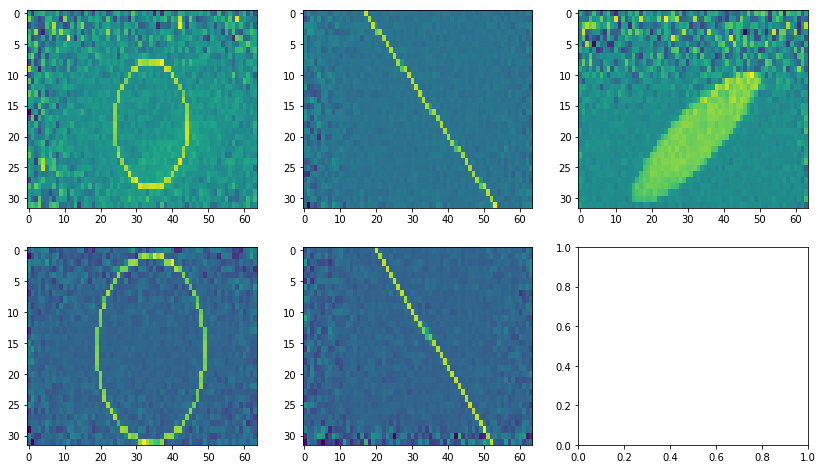

In [17]:
#new_kerns = active_kerns.copy()
f, ax = plt.subplots(2,3, figsize=(14,8))
for i, ds in enumerate(queues):
    if len(ds) < 50:
        continue
    temp = ds.copy()
    #temp.append(active_kerns[i])
    #print(len(temp), temp[1])
    corr_mat, cov_mat, shift_mat = cross_correlate_kernels(np.stack(temp, axis=0))
    cen_row, cen_col = np.unravel_index(np.asarray(shift_mat, dtype=np.int32), dims=ds[0].shape)
    w, v = np.linalg.eig(cov_mat)
    w = w.real; v = v.real
    R = cen_row
    C = cen_col
    print('evals', w[:5])

    res = combine_filters(temp, w, v.T, np.stack([R, C], axis=-1), cutoff=0.1)

    new_kerns[i] = res[0]  #update ith kernel
    #detections[i] = []     #reinitialize detections
    
    ax[i//3,i%3].imshow(res[0], aspect='auto')
plt.savefig('/home/yunfanz/Projects/presentations/template_res.jpg')
plt.show()
    


### Step 3 : Form new clusters

TODO: this step doesn't work very well


In [42]:
corr_mat, cov_mat, shift_mat = cross_correlate_kernels(np.stack(detections[-1], axis=0))
affinity_mat = np.clip(1-corr_mat, 1.e-16, 1)

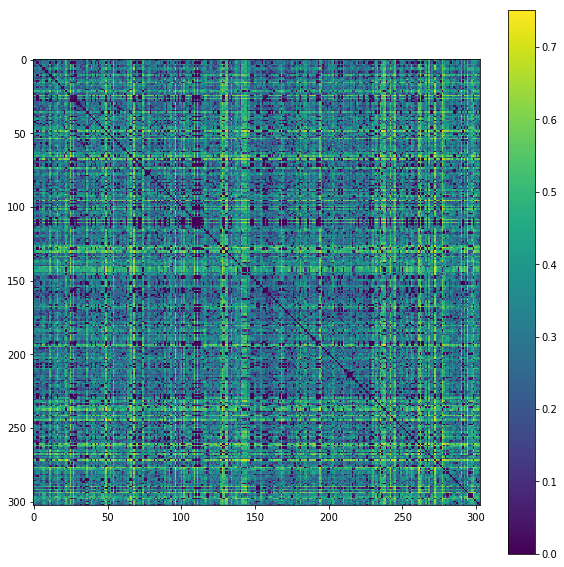

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(affinity_mat)
plt.colorbar()
plt.show()

evals [861.26809379 105.05089406 -22.18899881  49.70738554  26.05451354]


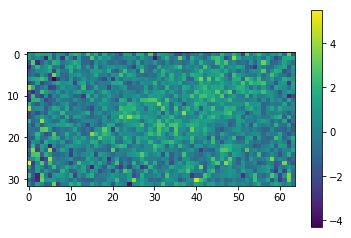

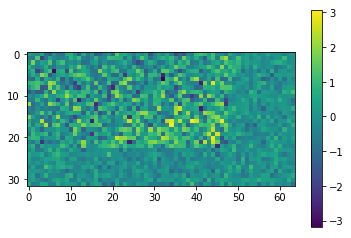

evals [1230.17723085  -62.34440788  -33.29752342    2.65904485   38.26318046]


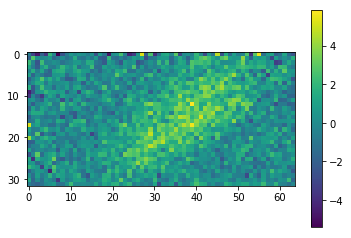

evals [527.18988886  67.6402142  -15.89986363]


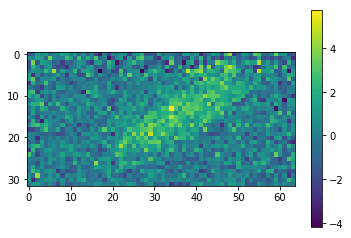

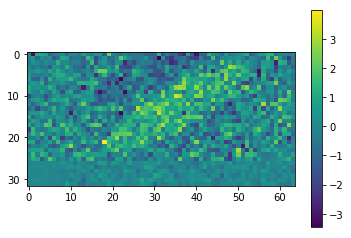

evals [9843.92247801 -553.11887382  575.56901561 -253.89289895  315.65668535]


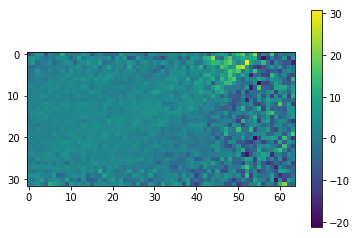

evals [538.20448273  -0.691462    46.39243037]


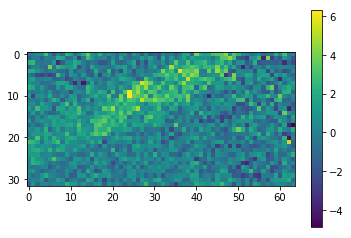

evals [13917.09750431 -3731.23027856  1117.38713443  -713.67806776
   605.23093626]


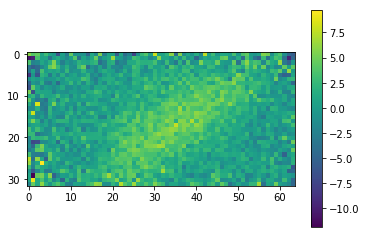

evals [550.51549868   2.94562799  58.76944237]


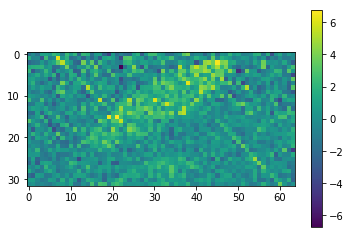

evals [1077.23122121  110.38239751  -35.53553831    2.13822224   34.81342003]


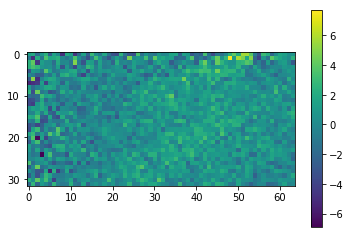

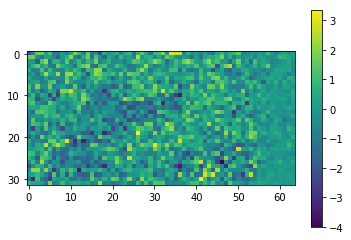

evals [1007.49097016  127.43406631  -62.77721406   16.99841755   23.1319365 ]


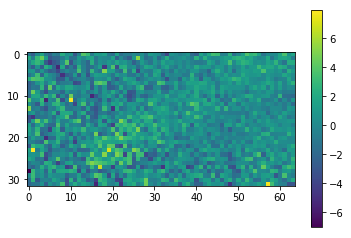

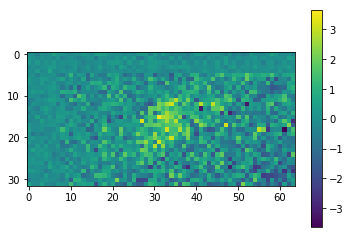

evals [ -1.55076777 461.60032377]


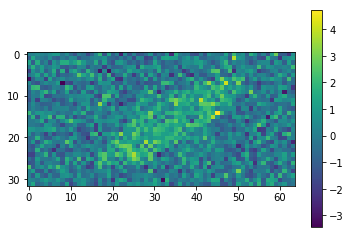

evals [28699.96974385 -3865.9192289  -1892.70342251  1617.99285466
  1168.14942674]


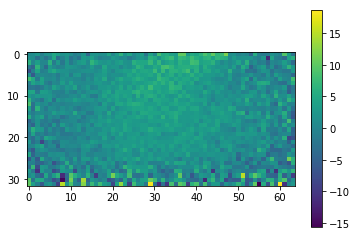

evals [8751.14933968 -679.23392002  441.17336201  301.63745157 -213.85246302]


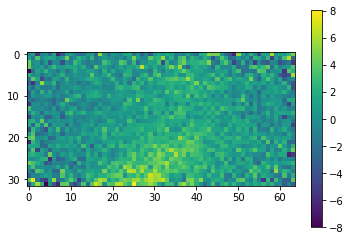

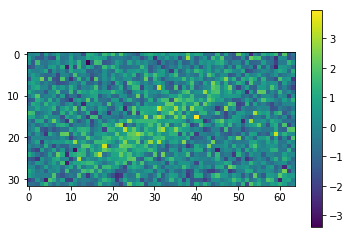

evals [368.62747673  15.05418092]


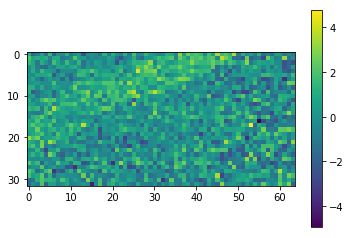

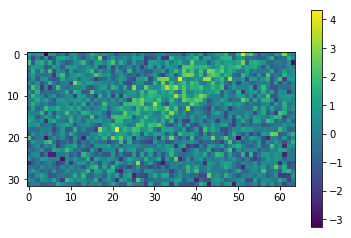

evals [8576.09232088  296.88941169 -273.70554616 -235.66251751 -208.12662805]


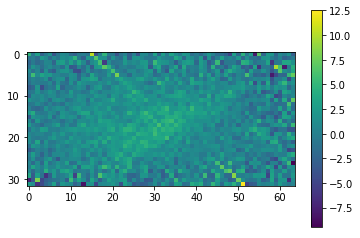

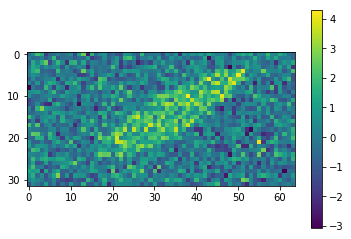

evals [504.40743182  46.26493235   5.3091257 ]


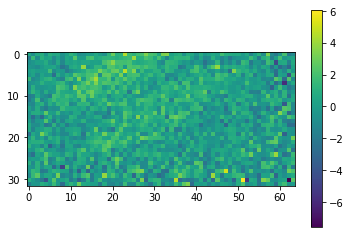

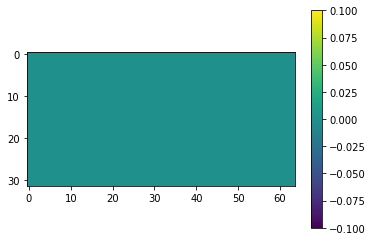

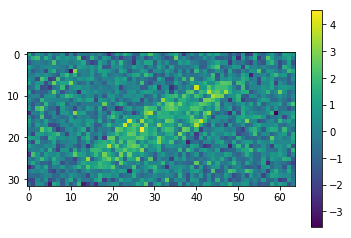

In [47]:
scanner = AgglomerativeClustering(n_clusters=10, linkage='average', affinity='precomputed')
clustering = scanner.fit(affinity_mat)
labels = np.unique(clustering.labels_)
clusters = []
for lab in labels:
    if lab < 0:
        continue
    clusters.append(np.where(clustering.labels_==lab)[0])
#Perform PCA on covariance matrices to keep the best components
new_kerns = []
for c in clusters:
    c = np.asarray(c)
    kerns = kernels[c]
    if c.size == 1:
        new_kerns.append(kerns[0])
        plt.figure()
        plt.imshow(kerns[0])
        plt.colorbar()
        plt.show()
        continue
    Y = cov_mat[np.ix_(c,c)]
    R = cen_row[np.ix_(c,c)]
    C = cen_col[np.ix_(c,c)]
    w, v = np.linalg.eig(Y)
    w = w.real; v = v.real
    print('evals', w[:5])

    res = combine_filters(kerns, w, v.T, np.stack([R, C], axis=-1))
    j = 0
    while w[j] > w[0]*0.05:
        new_kerns.append(res[j])  #only append first result from each cluster
        plt.figure()
        plt.imshow(res[j])#*(res[j]>0))
        plt.colorbar()
        plt.show()
        j += 1

# Next Steps

1. Implement convolutions in pytorch/tensorflow.
2. Test on real data. 
3. Test stability and with respect to various hyperparameters, modify design accordingly. 
4. Investigate transform invariant operations

## Autoencoders and potential drawbacks
One can imagine using just energy detection and a deep autoencoder (i.e. replace phase 1 and 2 with autoencoder). However, the autoencoder might have trouble with very unbalanced dataset. Optimal solutions to this should be tried when exploring this route. 

Cost function will also need experiment. If noise is too high, model can fail to learn